In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Plotting parameters

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (11.5, 10.5),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 3,
          'lines.markersize': 7,
          'font.family': 'sans-serif',
          'figure.autolayout': True}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

#### 1) Load the data
a) Give the paths to the data in /afs/.

b) Load the values of the transverse emittance in a dictionary.

In [3]:
n_runs = 5 # number of runs that the simulation was repeated
turns = 1e5
f_rev = 43375.86 # [Hz] The revolution frequency of the machine 
turns_list = np.arange(0,turns)
time = turns_list/f_rev # [s], type: list

# Relativistic parameters of the study, used for the post process analysis
neps_y = 2e-6 # m
gamma_0 = 287.8 
beta_0  = np.sqrt(1-1/gamma_0**2)

In [4]:
# Noise parameters
type_of_noise = 'PN'
rms_ksi_list =  [0.04, 0.06, 0.08, 0.2, 0.4, 0.6, 0.8]
peak= 0.18
# tune spread
delta_rms = 2.1e-4
ayy_min = -3e5 # -1e6 
ayy_max =  3e5  # 1e6
N_size = 10
ayy_list = list(np.linspace(ayy_min, ayy_max, N_size))

In [ ]:
ex_dict = {} # type: dictionary
ey_dict = {}
intensity = {}
for rms_ksi in rms_ksi_list:
    print('rmsksi={}'.format(rms_ksi)) # status of file loading
    path_to_data = '/afs/cern.ch/work/n/natriant/private/sixtracklib_example_crabcavity/tbt_from_GPUs/studies_with_constant_total_noise_power/long_rmsKsi{}/'.format(rms_ksi)
    for index, ayy in enumerate(ayy_list):
        #print(index) # status of file loading
        for run in range(n_runs):
            temp_name = 'DQ{}_rmsKsi{}_run{}'.format(ayy, rms_ksi, run) # the suffix of the name of the current study
            # A. load the turn by turn data in a dictionary
            temp_dict = pickle.load( open( path_to_data+'tbt_ayy{}_run{}.pkl'.format(index, run), "rb" ) )
            # B. Create a different list for each run and save the emittance values
            ex_dict[temp_name] = temp_dict['neps_x'] 
            ey_dict[temp_name] = temp_dict['neps_y']
            intensity[temp_name]= temp_dict['intensity']

rmsksi=0.04
rmsksi=0.06
rmsksi=0.08
rmsksi=0.2
rmsksi=0.4


#### 2) Plot all the runs for a given ayy, and rmsksi value

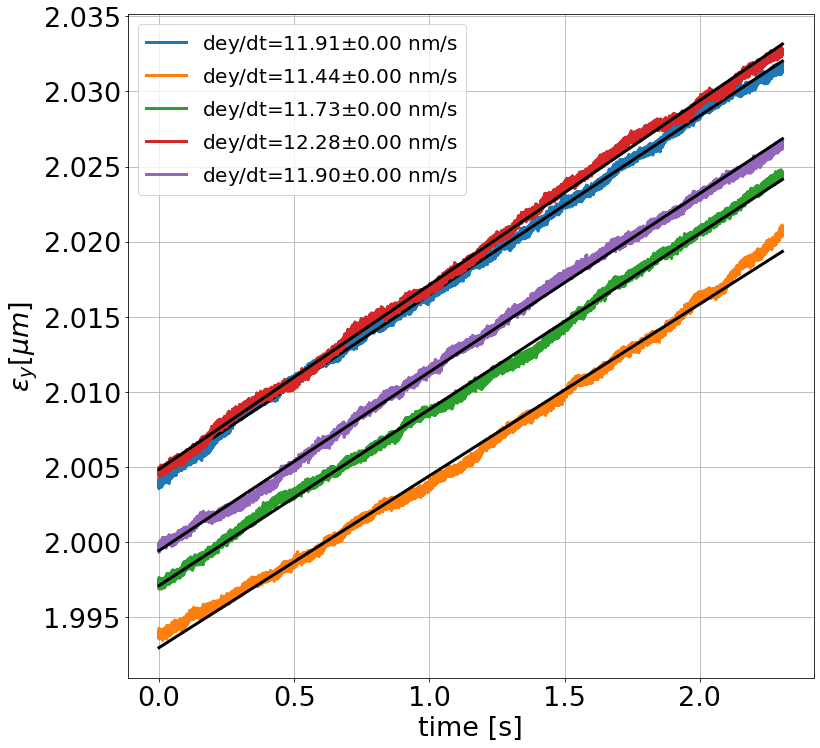

In [7]:
ayy = ayy_list[9]
rms_ksi = rms_ksi_list[-1]
for run in range(n_runs):
    temp_name = 'DQ{}_rmsKsi{}_run{}'.format(ayy, rms_ksi, run) # the suffix of the name of the current study       
    # linear fit
    [m, b], cov = np.polyfit(time, ey_dict[temp_name], 1, cov=True)
    # compute the error of the gradient of the fit slope
    err= np.sqrt(np.diag(cov))
    
    plt.plot(time, np.array(ey_dict[temp_name])*1e6, c='C{}'.format(run), label='dey/dt={0:.2f}'.format(m*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err[0]*1e9),)
    plt.plot(time, (m*time+b)*1e6, c = 'k'.format(run), linewidth = 3)
    
    
    plt.xlabel('time [s]')
    plt.ylabel(r'$\epsilon_y [\mu m]$')
    plt.legend(loc=0)
plt.grid()    
plt.tight_layout()

#### 3) Perform the linear fit for each one of the runs for each set of parameters

In [8]:
m_dict = {}
b_dict = {}
err_dict = {}
for run in range(n_runs):
    for ayy in ayy_list:
        for rms_ksi in rms_ksi_list:
            temp_name = 'DQ{}_rmsKsi{}_run{}'.format(ayy, rms_ksi, run) 
            # check for nan values in the emittance values, problem with rms_ksi_list[-3], run0 and ayy_list[9]
            emit = np.array(ey_dict[temp_name]) 
            check_nan = np.isnan(emit)
            if True in check_nan:
                print('Problem in study: {}'.format(temp_name))
                result = emit[np.logical_not(np.isnan(emit))] # remove all nan values
                time_2 = time[:len(result)]
                [m, b], cov = np.polyfit(time_2, result, 1, cov=True)
                err= np.sqrt(np.diag(cov))
            else:
                [m, b], cov = np.polyfit(time, ey_dict[temp_name], 1, cov=True)
                err= np.sqrt(np.diag(cov))
            
            m_dict[temp_name] = m
            b_dict[temp_name] = b
            err_dict[temp_name] = err

#### 4) Compute the mean and the std of the growth rates for each set of ayy and rms_ksi.

In [9]:
dey_mean = {}
dey_std = {}

for ayy in ayy_list:
    for rms_ksi in rms_ksi_list:
        m_list = []
        for run in range(n_runs):
            temp_name = 'DQ{}_rmsKsi{}_run{}'.format(ayy, rms_ksi, run) 
            m_list.append(m_dict[temp_name])
        dey_mean['DQ{}_rmsKsi{}'.format(ayy, rms_ksi)] = np.mean(m_list)
        dey_std['DQ{}_rmsKsi{}'.format(ayy, rms_ksi)] = np.std(m_list)

In [10]:
dey_mean = {}
dey_std = {}
for rms_ksi in rms_ksi_list:
    dey_mean['rmsKsi{}'.format(rms_ksi)] = []
    dey_std['rmsKsi{}'.format(rms_ksi)] = []
    for ayy in ayy_list:  
        m_list = []
        for run in range(n_runs):
            temp_name = 'DQ{}_rmsKsi{}_run{}'.format(ayy, rms_ksi, run) 
            m_list.append(m_dict[temp_name])
        dey_mean['rmsKsi{}'.format(rms_ksi)].append(np.mean(m_list))
        dey_std['rmsKsi{}'.format(rms_ksi)].append(np.std(m_list))
        

#### **8) Compute the rms tune spread**
**Detuning** due to octupole non-linearity for particles with given betatron amplitudes $A_x, A_y$ is given by:

\begin{equation}
\Delta \nu_y (J_y, J_x) = \nu_y(J_y, J_x) - \nu_{y_0} = \alpha_{yy} J_y - \alpha_{yx}J_x, (1)
\end{equation}
where th transverse actions $J_y$ and $J_x$ are given by:

\begin{equation}
J_{x,y} = \frac{A^2_{x,y}}{2\beta_{x,y}(s)}, (2)
\end{equation}
where $\beta_{x,y}(s)$ the beta function at the locations $s$ of the lattice.


**In our studies:** $\alpha_{yx}=0$ and therefore the equation (1) written as:

\begin{equation}
\Delta \nu_y (J_y) = \alpha_{yy} J_y, (3)
\end{equation}

Therefore, **the RMS tune spread**, from the Landau octupoles, can be computed by:
\begin{equation}
\Delta \nu_y (J_y)_{RMS} = \alpha_{yy}* 2*J_{y_{RMS}}, (4)
\end{equation}

, where the factor 2 is required to give the correct tune spread when Sixtracklib is used.

Note that $J_{y_{RMS}} = e_{y,geom} = e_{y,norm}/ \beta _0 \gamma_0$, where $\beta _0 \gamma_0$ the relativistic parameters of the reference particle

In [11]:
neps_y = 2e-6 # [m]
# Compute the initial RMS Jy. We assume that the initial normalised emittance for each study is 2μm. In reality when the distribuiton is created we don't get exaclty 2μm
Jy_rms = ey_geom = neps_y/(beta_0*gamma_0)# [m] 
DQy_rms = np.array(ayy_list)*2*Jy_rms

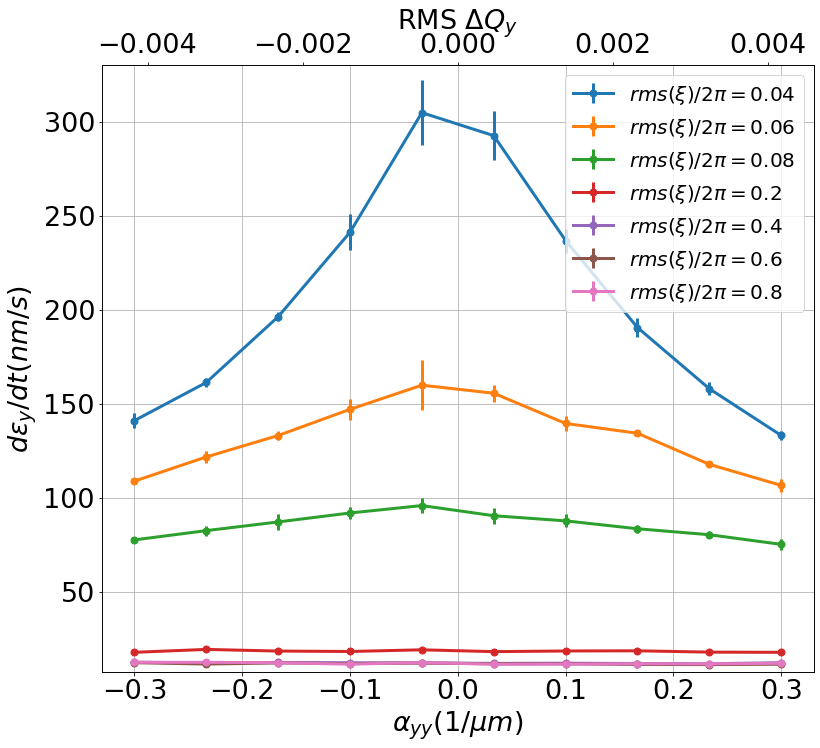

In [16]:
fig, ax1 = plt.subplots()
#rms_ksi_list = [0.2, 0.6]
for rms_ksi in rms_ksi_list:
    ax1.errorbar(np.array(ayy_list)/1e6, np.array(dey_mean['rmsKsi{}'.format(rms_ksi)])*1e9,yerr= np.array(dey_std['rmsKsi{}'.format(rms_ksi)])*1e9, marker ='o', label=r'$rms(\xi)  / 2 \pi = {} $'.format(rms_ksi))
ax1.set_xlabel(r'$\alpha_{yy} (1/\mu m)$')
ax1.set_ylabel(r'$d\epsilon_y /dt (nm/s)$')
ax1.grid()
ax1.legend(loc=0)

ax2 = ax1.twiny() 
ax2.plot(np.array(DQy_rms), np.zeros(len(ayy_list)), )
ax2.set_xlabel('RMS '+r'$\Delta Q_y $')

#plt.ylim(7.5, 28.0) # long bunch
#plt.ylim(7.5, 175) # short bunch, smaller ξ/2π=0.08
plt.ylim(7.5, 330) # short bunch

plt.tight_layout()
savefig = False
if savefig:
     plt.savefig('dey_vs_DQy_vs_rmsKsi_Qpx0_{}runs_ConstantPSD2_3e-21.png'.format(n_runs))


#### **9) Intensity**